# Modelling

Train and test model based on the features we have defined in the previous notebook.

In [43]:
%matplotlib inline

import os
import sys
import glob
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

Load data and print all features / columns that are present.

In [2]:
df_samples_all = pd.read_csv('s3://stormpetrels/samples/labels/samples_all.csv')
df_samples_all.columns.values

array(['freq_IQR', 'freq_Q25', 'freq_Q75', 'freq_mean', 'freq_median',
       'freq_mode', 'freq_peak', 'offset', 'onset', 'pitch_IQR',
       'pitch_Q25', 'pitch_Q75', 'pitch_max', 'pitch_mean',
       'pitch_median', 'pitch_min', 'yaafe_Chroma.0', 'yaafe_Chroma.1',
       'yaafe_Chroma.10', 'yaafe_Chroma.11', 'yaafe_Chroma.2',
       'yaafe_Chroma.3', 'yaafe_Chroma.4', 'yaafe_Chroma.5',
       'yaafe_Chroma.6', 'yaafe_Chroma.7', 'yaafe_Chroma.8',
       'yaafe_Chroma.9', 'yaafe_LPC', 'yaafe_LSF.0', 'yaafe_LSF.1',
       'yaafe_LSF.2', 'yaafe_LSF.3', 'yaafe_LSF.4', 'yaafe_LSF.5',
       'yaafe_LSF.6', 'yaafe_LSF.7', 'yaafe_LSF.8', 'yaafe_LSF.9',
       'yaafe_MFCC.0', 'yaafe_MFCC.1', 'yaafe_MFCC.10', 'yaafe_MFCC.11',
       'yaafe_MFCC.12', 'yaafe_MFCC.2', 'yaafe_MFCC.3', 'yaafe_MFCC.4',
       'yaafe_MFCC.5', 'yaafe_MFCC.6', 'yaafe_MFCC.7', 'yaafe_MFCC.8',
       'yaafe_MFCC.9', 'yaafe_OBSI.0', 'yaafe_OBSI.1', 'yaafe_OBSI.2',
       'yaafe_OBSI.3', 'yaafe_OBSI.4', 'yaafe_OBSI.5', 'ya

The data comes from number of files. Put some of them aside for testing and take rest for training.

In [3]:
df_samples_all['filename'].unique()

array(['STHELENA-02_20140605_200000_6', 'STHELENA-02_20140605_200000_9',
       'STHELENA-02_20140605_200000_5', 'STHELENA-02_20140605_200000_8',
       'STHELENA-02_20140605_200000_13', 'STHELENA-02_20140605_200000_3',
       'STHELENA-02_20140605_200000_11', 'STHELENA-02_20140605_200000_7',
       'STHELENA-02_20140605_200000_4', 'STHELENA-02_20140605_200000_1',
       'STHELENA-02_20140605_200000_10', 'STHELENA-02_20140605_200000_2',
       'STHELENA-02_20140605_200000_12'], dtype=object)

In [4]:
df_train = df_samples_all[~df_samples_all['filename'].str.contains('STHELENA-02_20140605_200000_1[0-9]')]
y_train = df_train.pop('petrel')
df_test = df_samples_all[df_samples_all['filename'].str.contains('STHELENA-02_20140605_200000_1[0-9]')]
y_test = df_test.pop('petrel')

`0` denotes *noise* and `1` *petrels*.

In [5]:
y_train.value_counts()

1    1626
0    1205
Name: petrel, dtype: int64

In [6]:
y_test.value_counts()

1    613
0    371
Name: petrel, dtype: int64

In [7]:
features =  ['freq_Q25', 'freq_Q75', 'freq_mean', 'freq_median',
       'freq_mode', 'freq_peak', 'pitch_IQR',
       'pitch_Q25', 'pitch_Q75', 'pitch_max', 'pitch_mean',
       'pitch_median', 'pitch_min', 'yaafe_LPC', 'yaafe_LSF.0', 'yaafe_LSF.1',
       'yaafe_LSF.2', 'yaafe_LSF.3', 'yaafe_LSF.4', 'yaafe_LSF.5',
       'yaafe_LSF.6', 'yaafe_LSF.7', 'yaafe_LSF.8', 'yaafe_LSF.9',
       'yaafe_MFCC.0', 'yaafe_MFCC.1', 'yaafe_MFCC.10', 'yaafe_MFCC.11',
       'yaafe_MFCC.12', 'yaafe_MFCC.2', 'yaafe_MFCC.3', 'yaafe_MFCC.4',
       'yaafe_MFCC.5', 'yaafe_MFCC.6', 'yaafe_MFCC.7', 'yaafe_MFCC.8',
       'yaafe_MFCC.9', 'yaafe_OBSI.0', 'yaafe_OBSI.1', 'yaafe_OBSI.2',
       'yaafe_OBSI.3', 'yaafe_OBSI.4', 'yaafe_OBSI.5', 'yaafe_OBSI.6',
       'yaafe_OBSI.7', 'yaafe_OBSI.8', 'yaafe_SpectralFlatness',
       'yaafe_SpectralFlux', 'yaafe_SpectralRolloff',
       'yaafe_SpectralVariation']

dtrain = xgb.DMatrix(df_train[features], label=y_train.values)
dtest = xgb.DMatrix(df_test[features], label=y_test.values)

In [8]:
param = {'max_depth': 3, 'eta': 0.1, 'silent': 0, 'objective': 'binary:logistic', 'subsample': 0.8, 'gamma': 0.1}
eval_metric = ["auc","error"]
watchlist = [(dtest, 'eval'), (dtrain, 'train')]

bst = xgb.train(param, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=20)

[0]	eval-error:0.013211	train-error:0.020487
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 20 rounds.
[1]	eval-error:0.009146	train-error:0.018368
[2]	eval-error:0.010163	train-error:0.018015
[3]	eval-error:0.009146	train-error:0.018368
[4]	eval-error:0.009146	train-error:0.018015
[5]	eval-error:0.010163	train-error:0.018721
[6]	eval-error:0.010163	train-error:0.018015
[7]	eval-error:0.010163	train-error:0.018015
[8]	eval-error:0.009146	train-error:0.018721
[9]	eval-error:0.009146	train-error:0.018015
[10]	eval-error:0.009146	train-error:0.018721
[11]	eval-error:0.009146	train-error:0.018015
[12]	eval-error:0.009146	train-error:0.018015
[13]	eval-error:0.009146	train-error:0.018015
[14]	eval-error:0.010163	train-error:0.018015
[15]	eval-error:0.010163	train-error:0.018015
[16]	eval-error:0.009146	train-error:0.018015
[17]	eval-error:0.009146	train-error:0.018015
[18]	eval-error:0.009146	train-erro

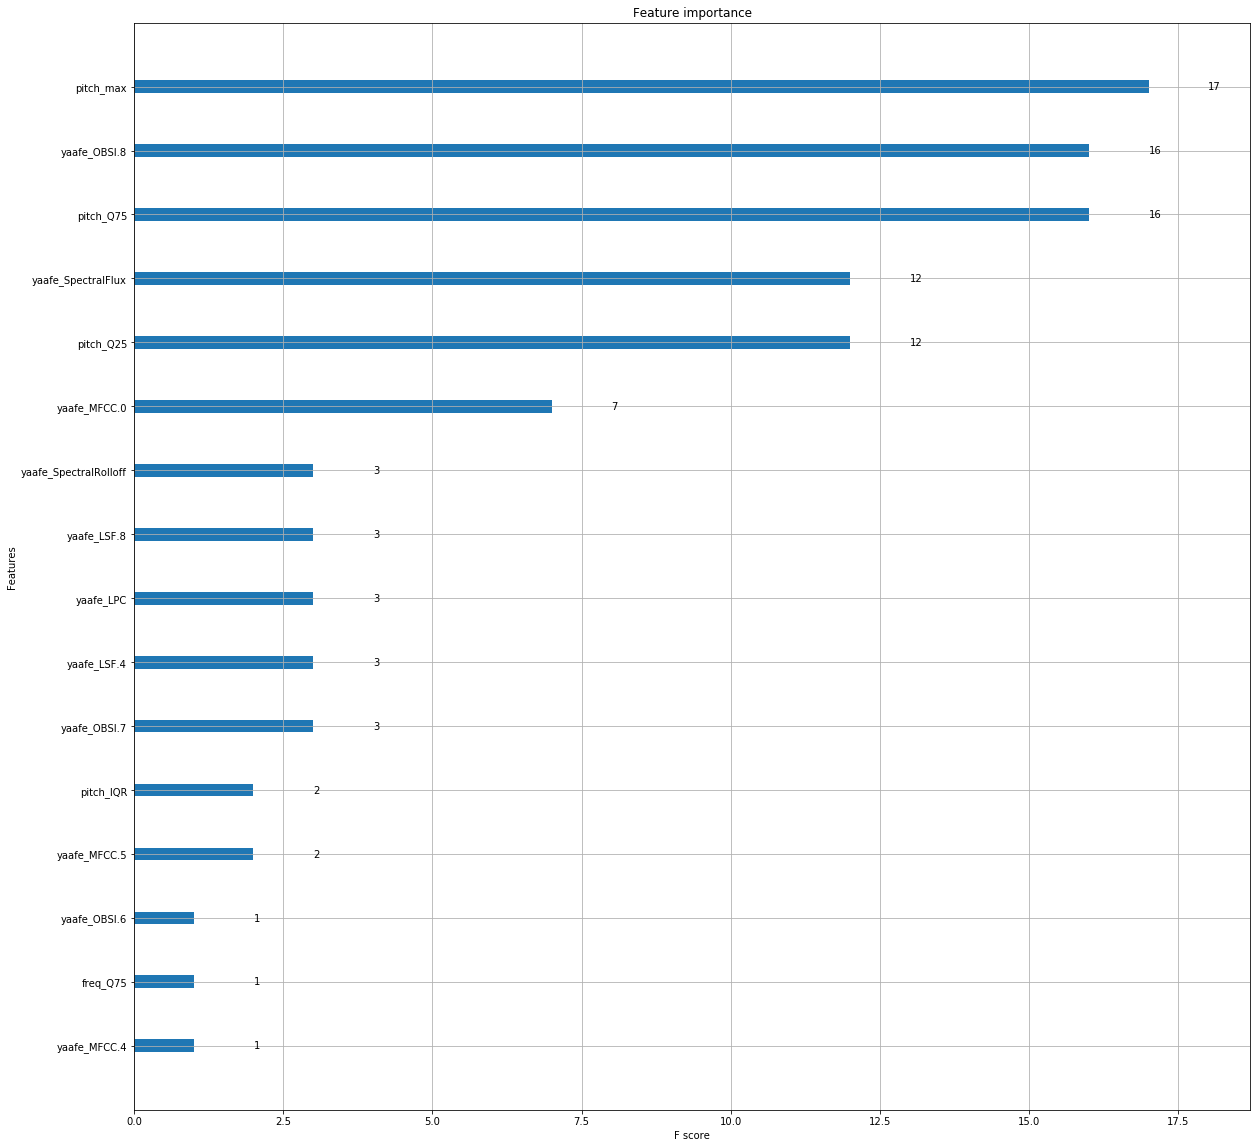

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(bst, ax=ax)

In [10]:
h5_files = glob.glob('../data/features/h5/*.h5')
dfs = []
for path in h5_files:
    df = pd.read_hdf(path)
    name = os.path.splitext(os.path.basename(path))[0]
    df['filename'] = name
    dfs.append(df)
    
dfs = pd.concat(dfs)
dfs = dfs.rename(columns={'freq_peak.1': 'freq_peak'})
dfs = dfs.drop(columns=['freq_peak.2', 'freq_peak.3'])
df_pred = dfs[features]
p = xgb.DMatrix(df_pred)
pred = bst.predict(p)
dfs['petrel_prob'] = pred
dfs['petrel'] = pred > 0.5

In [49]:
dfs = dfs.sort_values(by=['filename', 'onset'])
dfs.to_csv('storm_petrels_all.csv', index=False, float_format='%.3f')

In [11]:
sel_columns = ['filename', 'onset', 'offset', 'petrel', 'petrel_prob', 'freq_mean', 'freq_median', 'freq_mode',
       'freq_Q25', 'freq_Q75', 'freq_IQR', 'freq_peak', 'pitch_median', 'pitch_mean', 'pitch_Q25', 'pitch_Q75', 'pitch_IQR', 'pitch_min',
       'pitch_max']

df = dfs[sel_columns]
df = df.sort_values(by=['filename', 'onset'])

In [12]:
df.to_csv('storm_petrels.csv', index=False, float_format='%.3f')

In [13]:
sel_columns = ['filename', 'onset', 'offset', 'petrel', 'petrel_prob']
df[sel_columns].to_csv('storm_petrels_short.csv', index=False, float_format='%.3f')

In [47]:
sel_columns = ['filename', 'onset', 'offset', 'petrel', 'petrel_prob', 'freq_mean', 'freq_median', 'freq_mode',
       'freq_Q25', 'freq_Q75', 'freq_IQR', 'freq_peak', 'pitch_median', 'pitch_mean', 'pitch_Q25', 'pitch_Q75', 'pitch_IQR', 'pitch_min',
       'pitch_max']
df_petrels = df[df['petrel']][sel_columns]
df_petrels = df_petrels.sort_values(by=['filename', 'onset'])
df_petrels.to_csv('storm_petrels.csv', index=False, float_format='%.3f')

In [15]:
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

In [16]:
xgb_sk = XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='binary:logistic', silent=True, nthread=1)

In [25]:
params = {
 'max_depth': [3, 4, 5],
 'min_child_weight': [1, 3, 5],
 'gamma': [0.0, 1, 5],
 'alpha': [0.0, 0.1, 0.3],
 'colsample_bytree': [0.6, 0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb_sk, param_grid=params, scoring='roc_auc', n_jobs=7, cv=skf.split(df_train[features].values, y_train), verbose=3)

In [26]:
grid.fit(df_train[features].values, y=y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    6.5s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   35.9s
[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 498 tasks      | elapsed:  2.9min
[Parallel(n_jobs=7)]: Done 729 out of 729 | elapsed:  4.2min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f5fa9fe3518>,
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.02, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=1, objective='bi...c',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=7,
             param_grid={'alpha': [0.0, 0.1, 0.3],
                         'colsample_bytree': [0.6, 0.8, 1.0],
  

In [29]:
grid.best_score_

0.9982059363576122

In [39]:
with open('petrels.txt', 'w') as f:
    for path in h5_files:
        p = os.path.splitext(os.path.basename(path))[0]
        f.write(p + '\n')

In [38]:
h5_files.sort()

In [46]:
py.plot([go.Histogram(x=pred)], filename='Storm Petrel prediction score histogram') 

/home/tracek/anaconda3/envs/audioexplorer/lib/python3.6/site-packages/chart_studio/plotly/plotly.py:248: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



'https://plot.ly/~tracewsl/337?share_key=tEoim097Z1ncGf88vmGQmm'